In [822]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [823]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [824]:
data = torch.randint(low=-10, high=11, size=(2000,2)).float()
labels = torch.sum(data,axis=1, keepdim=True)

In [825]:
dataNorm = data / torch.max(data,axis=0).values
labelsNorm = labels / torch.max(labels,axis=0).values

In [826]:
# Create the data
#a = np.round(  np.linspace(-10,11,num=10000)  )
#np.random.shuffle(a)

#b = np.round(  np.linspace(-10,11,num=10000)  )
#np.random.shuffle(b)

#sumAB = np.sum(a, b)

#data = np.vstack((a,b)).T

In [827]:
# Normalize the data
# aNorm    = a / np.max(a)
# bNorm    = b / np.max(b)
# sumNorm  = sumAB / np.max(sumAB)
# dataNorm = np.vstack((aNorm, bNorm)).T

In [828]:
data.shape

torch.Size([2000, 2])

In [829]:
labels.shape

torch.Size([2000, 1])

In [830]:
# Step1: Convert numpy data into tensor data

xx = dataNorm
yy = labelsNorm
#xx = torch.tensor( data ).float()
#yy  = torch.tensor( labels  ).float()

In [831]:
# Step2: use scikit learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(xx, yy, test_size=0.1)

In [832]:
# Step 3: Convert into PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data  = TensorDataset(test_data , test_labels)

In [833]:
train_data.tensors[0].shape

torch.Size([1800, 2])

In [834]:
test_data.tensors[0].shape

torch.Size([200, 2])

In [835]:
# Step 4: Translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_data,  batch_size=test_data.tensors[0].shape[0])

In [836]:
# Create the Deep Learning Model
def createTheSumABNet():
    class sumABNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(2,20)
            
            # self.bnormHidden1 =  nn.BatchNorm1d(20)
            self.hidden1 = nn.Linear(20,10)
            
            # self.bnormHidden2 =  nn.BatchNorm1d(10)
            self.hidden2 = nn.Linear(10,5)
            
            self.output = nn.Linear(5,1)
            
        def forward(self, x):
            
            x = F.leaky_relu( self.input(x) )
            
            # x = self.bnormHidden1(x)
            x = F.leaky_relu( self.hidden1(x) )

            # x = self.bnormHidden2(x)
            x = F.leaky_relu( self.hidden2(x) )
                        
            x = self.output(x)
            
            return x
        
    sumModel = sumABNet().to(device)
    
    lossfun = nn.MSELoss()
    
    optimizer = torch.optim.Adam(sumModel.parameters(), lr=0.01)#, betas=(0.9, 0.999), eps=1e-8)
    
    return sumModel, lossfun, optimizer

In [837]:
# test the model that is has NO ERRORS!

sumNet2, lossfun, optimizer = createTheSumABNet()

input = torch.rand(1,2).to(device)
sumNet2.eval()
sumNet2(input)
print(input)
sumNet2.train()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5 and 10x1)

In [ ]:
# Train the Model

def trainTheModel(sumTrain, lossfun, optimizer):
    
    #number of epochs to train
    numepochs = 50
        
    #initialize losses & accuracy
    losses   = torch.zeros(numepochs)
    trainAcc = []
    testAcc  = []
    
    for epochi in range(numepochs):
        
        #batch loss & accuracy
        batchLoss = []
        batchAcc  = []
        
        #loop over mini-batches
        for X,y in train_loader:
            
            # push data to GPU
            X = X.to(device)
            y = y.to(device)
            
            #Forward pass & loss
            yHat = sumTrain(X)
            loss = lossfun(yHat, y)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #loss from this batch
            batchLoss.append(loss.item())
            
            # accuracy from this batch for categorical data
            batchMathces = (torch.abs(yHat - y)).detach().cpu().float().numpy()
            batchAcc.append(( batchMathces < 1))
            
            #accuracy from this batch -> for BCE
            # matches = torch.argmax(yHat,axis=1) == y ##????????????????
            # matchesNumeric = matches.float()
            # batchAcc.append( 100*torch.mean(matchesNumeric).item() )
        
        #average accuracy across mini-batches
        trainAcc.append(100 * np.mean((batchAcc)))
        
        #average losses across all mini-batches
        losses[epochi] = np.mean(batchLoss)
        
        ################################
        
        #final forward pass for Test Accuracy
        X,y = next(iter(test_loader))
        
        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            yHat = sumTrain(X)
            
        #compute the test accuracy
        testMatches = (torch.abs(yHat - y)).detach().cpu().float().numpy()
        testMatchesNumeric = (testMatches < 1)
        testAcc.append(100 * np.mean( testMatchesNumeric ) )
    
    return trainAcc, testAcc, losses, sumTrain

In [ ]:
# Test the training code that it has NO ERRORS
sumModel, lossfun, optimizer = createTheSumABNet()
trainAcc, testAcc, losses, sumModelTrained = trainTheModel(sumModel, lossfun, optimizer)

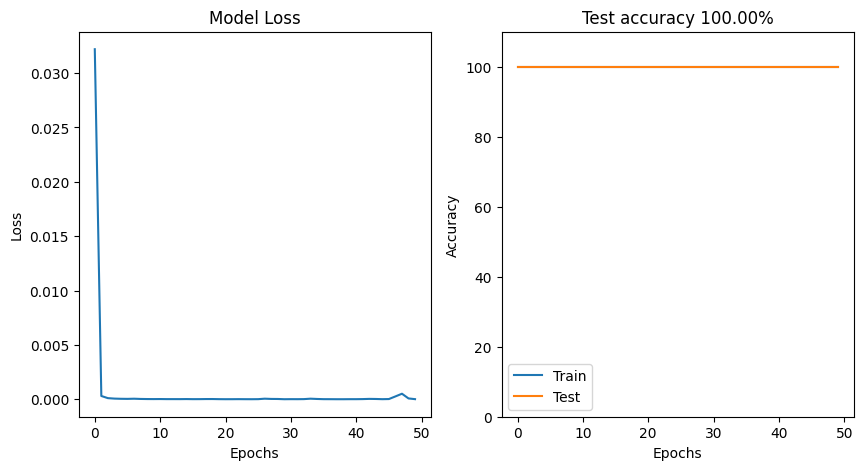

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Test accuracy {testAcc[-1]:.2f}%')
ax[1].set_ylim([0,110])

plt.show()

Text(0.5, 1.0, 'predicted vs actual sum')

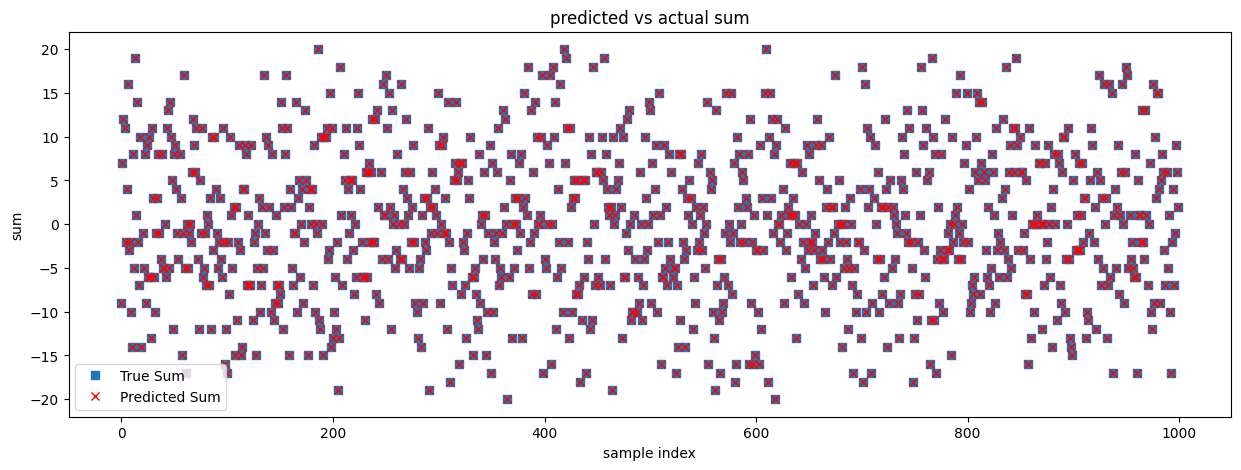

In [ ]:
dataIN = torch.randint(low=-10, high=11, size=(1000,2)).float().to(device)
dataINNorm = dataIN / torch.max(data,axis=0).values.to(device)
labelsOUT = torch.sum(dataIN, axis=1, keepdim=True)

with torch.no_grad():
    predictionsNorm = sumModelTrained(dataINNorm)
    
predictions = predictionsNorm * torch.max(labelsOUT, axis=0).values.to(device)

fig = plt.figure(figsize=(15,5))
plt.plot(labelsOUT.detach().cpu(), 's') #s = square
plt.plot(torch.round(predictions).detach().cpu(), 'rx') #r red ... x = cross
plt.legend(['True Sum', 'Predicted Sum'])
plt.xlabel('sample index')
plt.ylabel('sum')
plt.title('predicted vs actual sum')

In [ ]:
#for i in range(10):
#    sumModel, lossfun, optimizer = createTheSumABNet()
#    trainAcc, testAcc, losses, sumModelTrained = trainTheModel(sumModel, lossfun, optimizer)
#    
#    print(f'Mode instance {i+1}, \n \tfinal Train accuracy: {trainAcc[-1]}, \n \tfinal Test accuracy: {testAcc[-1]}, \n \tfinal Loss {losses[-1]}')